In [1]:
# ==============================================================================
# CÉLULA DE SETUP: IMPORTAÇÕES E CARREGAMENTO DOS DADOS PROCESSADOS
# ==============================================================================

# --- Importações de Bibliotecas ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# --- Configurações Globais ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# --- Carregamento dos Dados ---
CAMINHO_DADOS_PROCESSADOS = '../data/processed/dados_consolidados_produtividade_co_2017-2023.csv'
try:
    df_final = pd.read_csv(CAMINHO_DADOS_PROCESSADOS)
    print("Setup concluído. DataFrame 'df_final' carregado com sucesso.")
    print(f"Total de registros: {len(df_final)}")
except FileNotFoundError:
    print(f"ERRO: Arquivo processado não encontrado. Execute o notebook de ETL primeiro.")

Setup concluído. DataFrame 'df_final' carregado com sucesso.
Total de registros: 3026


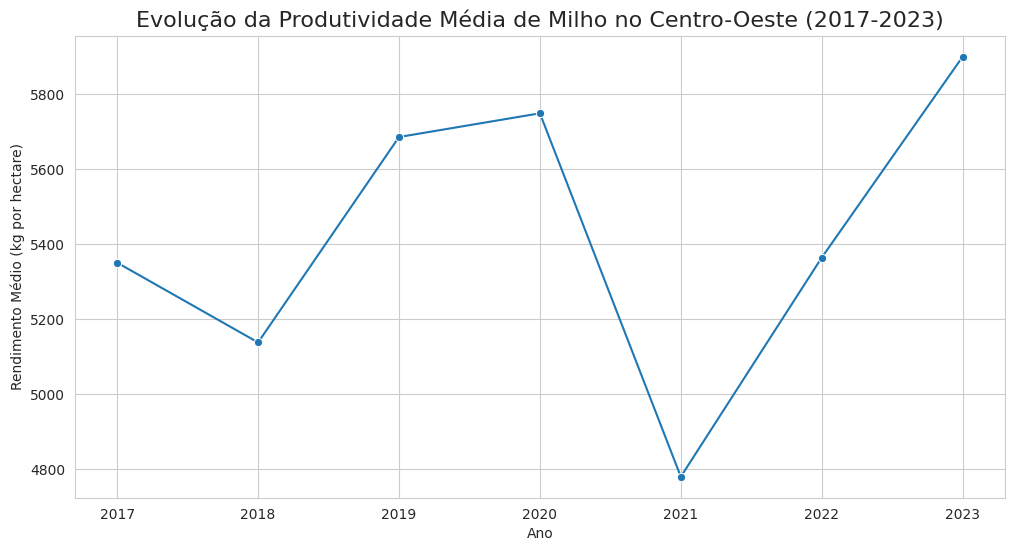

In [2]:
# --- ANÁLISE: Evolução da Produtividade no Tempo ---
produtividade_anual_media = df_final.groupby('ano')['rendimento_medio_kg_ha'].mean()

sns.lineplot(x=produtividade_anual_media.index, y=produtividade_anual_media.values, marker='o')
plt.title('Evolução da Produtividade Média de Milho no Centro-Oeste (2017-2023)', fontsize=16)
plt.xlabel('Ano')
plt.ylabel('Rendimento Médio (kg por hectare)')
plt.show()

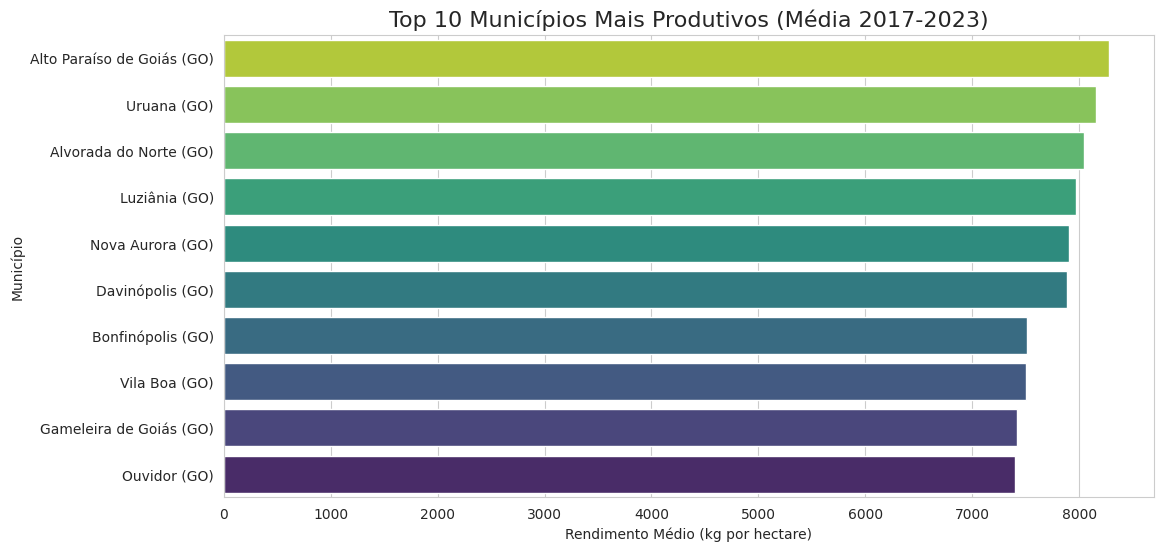

In [3]:
# --- ANÁLISE: Top 10 Municípios Mais Produtivos ---
media_por_municipio = df_final.groupby(['municipio_nome', 'uf'])['rendimento_medio_kg_ha'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=media_por_municipio.values, y=[f"{nome} ({uf})" for nome, uf in media_por_municipio.index], palette='viridis_r')
plt.title('Top 10 Municípios Mais Produtivos (Média 2017-2023)', fontsize=16)
plt.xlabel('Rendimento Médio (kg por hectare)')
plt.ylabel('Município')
plt.show()